# Import packages
run the following cell to import necessary packages to run the analysis

In [ ]:
import os
from pathlib import Path

import dask.array as da
import xarray as xr
import tifffile
import ngff_zarr

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
# from pylibCZIrw import czi as pyczi
# from bioio import BioImage
# import bioio_czi

# Reading data

In [2]:
data_path = Path('/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250325/test_dir/')
filelist = os.listdir(data_path)
print(len(filelist))

2


In [3]:
filelist = [x for x in filelist if x.find('.czi')>0]
filelist.sort()
filelist

['NPM_Ex010_Re03_gel_Im-02_AcquisitionBlock3_pt3_sub1-Scene-1-Airyscan Processing-05_2.czi']

In [4]:
file_index = 0
file_path = str(data_path)+'/'+filelist[file_index]
filename = filelist[file_index][:filelist[file_index].index('.czi')]
print(file_path)
print(filename)

/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250325/test_dir/NPM_Ex010_Re03_gel_Im-02_AcquisitionBlock3_pt3_sub1-Scene-1-Airyscan Processing-05_2.czi
NPM_Ex010_Re03_gel_Im-02_AcquisitionBlock3_pt3_sub1-Scene-1-Airyscan Processing-05_2


In [5]:
save_path = Path(str(data_path)+'/split_czi')
save_path.mkdir(parents=True, exist_ok=True)
print(save_path)

/mnt/Data/nuno_martins/Image_data/Ex010_Re01/ExM/20250325/test_dir/split_czi


___
with Zeiss library `pylibczirw`


In [6]:
from pylibCZIrw import czi as pyczi

In [7]:
with pyczi.open_czi(file_path) as czidoc:
    md_xml = czidoc.raw_metadata

# with open('./xml_metadata_airyscan.xml', 'w') as output:
#     output.write(md_xml)

In [ ]:
md_xml

In [ ]:
with pyczi.open_czi(file_path) as czidoc:
    md_dic = czidoc.metadata
    # print(md_xml[:1000])
    dims_all = czidoc.scenes_bounding_rectangle_no_pyramid
    print(dims_all)
    bd = czidoc.scenes_bounding_rectangle
    print(bd)
    tbd = czidoc.total_bounding_box
    print(tbd)
    pixel_types = czidoc.pixel_types
    print(pixel_types)

{0: Rectangle(x=2143565, y=736187, w=3632, h=3632)}
{0: Rectangle(x=2143565, y=736187, w=3632, h=3632)}
{'T': (0, 1), 'Z': (0, 344), 'C': (0, 6), 'H': (0, 2), 'X': (2143565, 2147197), 'Y': (736187, 739819)}
{0: 'Gray8', 1: 'Gray8', 2: 'Gray8', 3: 'Gray8', 4: 'Gray8', 5: 'Gray8'}


In [10]:
channels_display = md_dic['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel']
# channels_display = md_dic['ImageDocument']['Metadata']['DisplaySetting']['Channels']
# len(channels_display), channels_display[1]
for i in range(len(channels_display)):
    print(channels_display[i])

{'@Id': 'Channel:0', '@Name': 'AF647-T1', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color': '#FFFF0014', 'OriginalColor': '#FFFF0014'}
{'@Id': 'Channel:1', '@Name': 'AF647#-T1', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color': '#FFFF0014', 'OriginalColor': '#FFFF0014'}
{'@Id': 'Channel:2', '@Name': 'AF568-T2', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color': '#FFFF6600', 'OriginalColor': '#FFFF6600'}
{'@Id': 'Channel:3', '@Name': 'AF568#-T2', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color': '#FFFF6600', 'OriginalColor': '#FFFF6600'}
{'@Id': 'Channel:4', '@Name': 'DAPI-T3', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color': '#FF00A1FF', 'OriginalColor': '#FF00A1FF'}
{'@Id': 'Channel:5', '@Name': 'DAPI#-T3', 'BitCountRange': '8', 'PixelType': 'Gray8', 'IlluminationType': 'Fluorescence', 'Color'

In [ ]:
# channel_names = md_dic['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][1]['@Name']
# channel_names

first_ind = 4

channel_names = {}
for i in range(first_ind, first_ind+2):
    # print(md_dic['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i]['@Name'])
    channel_names[i] = md_dic['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i]['@Name']

channel_names.keys(), channel_names.values()

In [ ]:
image_document_name = md_dic['ImageDocument']['Metadata']['Experiment']['AutoSave']['Name']
image_document_name

In [ ]:
image_scaling_1_id = md_dic['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['@Id']
image_scaling_1_value = md_dic['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value']
image_scaling_2 = md_dic['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][1]['@Id']
image_scaling_3 = md_dic['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][2]['@Id']
image_scaling_1_id, image_scaling_1_value, image_scaling_2, image_scaling_3

In [12]:
def getDimensionPosition(dimension_order, dimension_name):
    return dimension_order.index(dimension_name)

In [29]:
# image_data = []
image_data = np.zeros((int(tbd['H'][1]), int(tbd['C'][1]), 1, bd[0].h, bd[0].w))
with pyczi.open_czi(file_path) as czidoc:
    for chan in range(int(tbd['C'][1])):
        for phase in range(int(tbd['H'][1])):
            # image_data.append(
            temp_image = czidoc.read(plane={'C': chan, 'H': phase, 'Z': (tbd['Z'][1]//2)})
            image_data[phase][chan][0] = temp_image.squeeze()
            # )

In [ ]:
image_data.shape

In [ ]:
print(len(image_data))
# image_data = np.array(image_data)
# print(image_data.shape)

In [ ]:
fig = plt.figure(figsize=(24,12))
for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        plt.subplot(image_data.shape[0], image_data.shape[1], i * image_data.shape[1] + j + 1)
        graph = image_data[i][j].squeeze()
        # if pmin!=0 or pmax!=100:
        #     img = normalize(img,pmin=pmin,pmax=pmax,clip=True)
        plt.imshow(
            graph,
            cmap='magma',
            vmin=np.percentile(graph, 1),
            vmax=np.percentile(graph, 99),
            )
        plt.axis("off")

In [ ]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(2, 2, 1)
# temp_image = image_data[1][0].squeeze()
x_start, x_end, y_start, y_end = 2000, 2500, 0, 500

plt.imshow(
    # temp_image,
    image_data[0][0][0][y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(image_data[0][0][0][y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(image_data[0][0][0][y_start:y_end, x_start:x_end], 99),
    )
plt.title('min: '+str(image_data[0][0][0][y_start:y_end, x_start:x_end].min())+' max:'+str(image_data[0][0][0][y_start:y_end, x_start:x_end].max()))

fig.add_subplot(2, 2, 2)
plt.imshow(
    image_data[0][1][0][y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(image_data[0][1][0][y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(image_data[0][1][0][y_start:y_end, x_start:x_end], 99),
    )
plt.title('min: '+str(image_data[0][1][0][y_start:y_end, x_start:x_end].min())+' max:'+str(image_data[0][1][0][y_start:y_end, x_start:x_end].max()))

fig.add_subplot(2, 2, 3)
plt.imshow(
    image_data[1][0][0][y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(image_data[1][0][0][y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(image_data[1][0][0][y_start:y_end, x_start:x_end], 99),
    )
plt.title('min: '+str(image_data[1][0][0][y_start:y_end, x_start:x_end].min())+' max:'+str(image_data[1][0][0][y_start:y_end, x_start:x_end].max()))

fig.add_subplot(2, 2, 4)
plt.imshow(
    image_data[1][1][0][y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(image_data[1][1][0][y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(image_data[1][1][0][y_start:y_end, x_start:x_end], 99),
    )
plt.title('min: '+str(image_data[1][1][0][y_start:y_end, x_start:x_end].min())+' max:'+str(image_data[1][1][0][y_start:y_end, x_start:x_end].max()))
plt.show()

___
with `aicspylibczi`


In [7]:
from aicspylibczi import CziFile

In [15]:
image_loader = CziFile(file_path)
image_loader.dims, image_loader.size

('STCZMYX', (1, 1, 3, 238, 4, 4084, 4084))

In [16]:
image_loader.get_dims_shape()

[{'X': (0, 4084),
  'Y': (0, 4084),
  'Z': (0, 238),
  'C': (0, 3),
  'T': (0, 1),
  'M': (0, 4),
  'S': (0, 1)}]

In [17]:
img_metada = image_loader.meta

In [ ]:
for child in img_metada:
    print('child ', child.tag, child.attrib)
    for gchild in child:
        print('gchild ', gchild.tag, gchild.attrib)

In [ ]:
# len(img_metada[0][4])
# img_metada[0][4][0]
display_settings = img_metada[0][4][0][:2]

for child in display_settings:
    print(child.tag, child.attrib)

In [12]:
def getDimensionPosition(dimension_order, dimension_name):
    return dimension_order.index(dimension_name)

In [ ]:
temp_image = np.zeros((image_loader.size[getDimensionPosition(image_loader.dims, 'H')], 1, 1, 2, 1, image_loader.size[getDimensionPosition(image_loader.dims, 'Y')], image_loader.size[getDimensionPosition(image_loader.dims, 'X')]))
temp_image.shape

In [ ]:
z = image_loader.size[getDimensionPosition(image_loader.dims, 'Z')] // 2
z

In [ ]:
temp = image_loader.read_image(H=0, S=0, T=0, C=0, Z=z)
temp[1]

In [ ]:
temp_image = []
for phase in range(image_loader.size[getDimensionPosition(image_loader.dims, 'H')]):
    for chan in range(2):
        if (phase == 1 and chan == 1):
            continue
        #try:
        temp = image_loader.read_image(H=phase, S=0, T=0, C=chan, Z=z)
        print(temp[0].shape, temp[1])
        temp_image.append(temp[0])
        #except:
         #   continue

In [ ]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(2, 2, 1)
# temp_image = image_data[1][0].squeeze()
x_start, x_end, y_start, y_end = 2000, 2500, 0, 500

plt.imshow(
    # temp_image,
    temp_image[0].squeeze()[y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(temp_image[0].squeeze()[y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(temp_image[0].squeeze()[y_start:y_end, x_start:x_end], 99),
    )

fig.add_subplot(2, 2, 2)
plt.imshow(
    temp_image[1].squeeze()[y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(temp_image[1].squeeze()[y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(temp_image[1].squeeze()[y_start:y_end, x_start:x_end], 99),
    )

fig.add_subplot(2, 2, 3)
plt.imshow(
    temp_image[2].squeeze()[y_start:y_end, x_start:x_end],
    cmap='magma',
    vmin=np.percentile(temp_image[2].squeeze()[y_start:y_end, x_start:x_end], 1),
    vmax=np.percentile(temp_image[2].squeeze()[y_start:y_end, x_start:x_end], 99),
    )

___
with `bioio` and `bioio-czi`


In [6]:
from bioio import BioImage
import bioio_czi

In [7]:
img = BioImage(
    file_path, 
    reader=bioio_czi.Reader, 
    reconstruct_mosaic=False,
    include_subblock_metadata=True,
    use_aicspylibczi=True,
    )
img.dims, img.dims.order

(<Dimensions [M: 4, T: 1, C: 3, Z: 238, Y: 4084, X: 4084]>, 'MTCZYX')

In [8]:
img.scale, img.channel_names

(Scale(T=None, C=None, Z=0.4, Y=0.04708196466619325, X=0.04708196466619325),
 [np.str_('AF647-T1'), np.str_('AF488-T2'), np.str_('DAPI-T3')])

In [9]:
img.scenes, img.shape

(('TR1',), (4, 1, 3, 238, 4084, 4084))

In [19]:
img.current_scene

'TR1'

In [10]:
tile_start_points = img.get_mosaic_tile_positions()
tile_start_points

[(0, 0), (0, 3686), (3687, 3686), (3687, 0)]

In [16]:
temp_img = img.get_image_dask_data(img.dims.order[1:], M=1)
temp_image = temp_img.compute()
# temp_img = img.get_image_data(img.dims.order[1:], M=0)

In [17]:
temp_image.shape

(1, 3, 238, 4084, 4084)

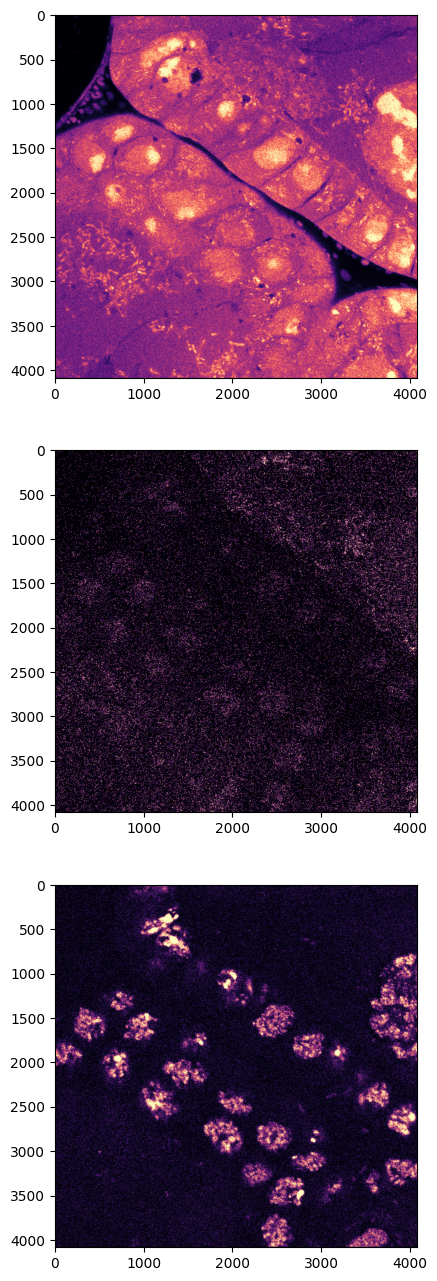

In [18]:
fig = plt.figure(figsize=(8,16))
fig.add_subplot(3, 1, 1)
# temp_image = image_data[1][0].squeeze()
# x_start, x_end, y_start, y_end = 2000, 2500, 0, 500

plt.imshow(
    # temp_image,
    temp_image[0, 0, temp_image.shape[2]//2],
    cmap='magma',
    vmin=np.percentile(temp_image[0, 0, temp_image.shape[2]//2], 1),
    vmax=np.percentile(temp_image[0, 0, temp_image.shape[2]//2], 99),
    )

fig.add_subplot(3, 1, 2)
plt.imshow(
    temp_image[0, 1, temp_image.shape[2]//2],
    cmap='magma',
    vmin=np.percentile(temp_image[0, 1, temp_image.shape[2]//2], 1),
    vmax=np.percentile(temp_image[0, 1, temp_image.shape[2]//2], 99),
    )

fig.add_subplot(3, 1, 3)
plt.imshow(
    temp_image[0, 2, temp_image.shape[2]//2],
    cmap='magma',
    vmin=np.percentile(temp_image[0, 2, temp_image.shape[2]//2], 1),
    vmax=np.percentile(temp_image[0, 2, temp_image.shape[2]//2], 99),
    )

### bioio Metadata mining
getting info from Metadata

In [32]:
meta = img.standard_metadata
meta

StandardMetadata(binning=None, column=None, dimensions_present='TCZMYX', image_size_c=3, image_size_t=1, image_size_x=4084, image_size_y=4084, image_size_z=238, imaged_by=None, imaging_date=None, objective=None, pixel_size_x=0.04708196466619325, pixel_size_y=0.04708196466619325, pixel_size_z=0.4, position_index=None, row=None, timelapse=True, timelapse_interval=None, total_time_duration=None)

In [33]:
vars(meta)

{'binning': None,
 'column': None,
 'dimensions_present': 'TCZMYX',
 'image_size_c': 3,
 'image_size_t': 1,
 'image_size_x': 4084,
 'image_size_y': 4084,
 'image_size_z': 238,
 'imaged_by': None,
 'imaging_date': None,
 'objective': None,
 'pixel_size_x': 0.04708196466619325,
 'pixel_size_y': 0.04708196466619325,
 'pixel_size_z': 0.4,
 'position_index': None,
 'row': None,
 'timelapse': True,
 'timelapse_interval': None,
 'total_time_duration': None}

___ 
Read and write airyscan data

### save single channel for processing with pyczi

In [ ]:
# channel_index = 2
# channel_range = 2 # the number ariyscan data channels per acquired channel
# for channel in range(channel_index, channel_index + channel_range):
#     print(channel)

In [13]:
channel_index = 0
channel_range = 2 # the number ariyscan data channels per acquired channel

with pyczi.open_czi(file_path) as czidoc_r:
    tbd = czidoc_r.total_bounding_box
    bd = czidoc_r.scenes_bounding_rectangle
    file_metadata = czidoc_r.metadata

    image_name = file_metadata['ImageDocument']['Metadata']['Experiment']['AutoSave']['Name']
    original_display_metadata = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][:2]

    channels_display = {}
    for i in range(channel_range):
        original_display_metadata[i] = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i+channel_index]

    pixelsize_x = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value'])
    pixelsize_y = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][1]['Value'])
    pixelsize_z = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][2]['Value'])
    
    channel_names = {}
    for i in range(channel_range):
        channel_names[i] = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i+channel_index]['@Name']

    # print(channels_display)
    # print(channel_names)
    # stop

    save_file_path = str(save_path)+'/'+filename+'_ch'+str(channel_index+1)+'.czi'
    with pyczi.create_czi(save_file_path, exist_ok=True) as czidoc_w:
        for t in range(tbd['T'][-1]):
            for slice in tqdm(range(tbd['Z'][-1])):
                for channel in range(channel_index, channel_index + channel_range):
                    for phase in range(tbd['H'][-1]):
                        slice_temp = czidoc_r.read(plane={'T': t, 'Z': slice, 'C': channel, 'H': phase})
                        czidoc_w.write(
                            data=slice_temp,
                            plane={
                                'H': phase,
                                'T': t,
                                'Z': slice,
                                'C': (channel-channel_index), # this bit is needed to write as channel 0 or 1
                            },
                            compression_options = "zstd0:ExplicitLevel=2",
                        )
        
        czidoc_w.write_metadata(
            image_name,
            channel_names = channel_names,
            scale_x = pixelsize_x,
            scale_y = pixelsize_y,
            scale_z = pixelsize_z,
            display_settings = channels_display
        )




  0%|          | 0/344 [00:00<?, ?it/s]

from Zeiss' website

In [ ]:
# data = inference_service.run() # [2, y, x] array with 2 being the number of classes.

# with czi.open_czi(path, 'w'):

#     class_nuclei = data[0,:,:]
#     channel_0 = { 'C': 0 }

#     czi.write(data=class_nuclei, location=(0,0), plane=channel_0, compression_options = "zstd0:ExplicitLevel=0" )

#     class_background = data[1,:,:]
#     channel_1 = { 'C': 1 }

#     czi.write(data=class_background, location=(0,0), plane=channel_1, compression_options = "zstd1:ExplicitLevel=2" )

#     # If we stopped here, we'd have a valid CZI. But we want to name the channels after the classes.

#     channel_names = { 0: "C1", 1: "C2" }
#     custom_attributes = {"key1": "value1", "key2": "value2"}

#     czi.write_metadata(channel_names=channel_names, scale_x=0.1 * 1e-6, scale_y=0.1 * 1e-6, custom_attributes=custom_attributes)

#     # If we want to specify specific colors for specific channels, we write as follows:
#     # In this case we are specifying c1 as blue and c2 as green.
    
#     display_setting_dict: Dict[int, ChannelDisplaySettingsDataClass] = {}
#     tint_color_c1 = Rgb8Color(np.uint8(0x00), np.uint8(0xFF), np.uint8(0x00))
#     channel_setting_c1 = ChannelDisplaySettingsDataClass(True, TintingMode.Color, tint_color_c1)
#     display_setting_dict[0] = channel_setting_c1
#     tint_color_c2 = Rgb8Color(np.uint8(0x00), np.uint8(0x00), np.uint8(0xFF))
#     channel_setting_c2 = ChannelDisplaySettingsDataClass(True, TintingMode.Color, tint_color_c2)
#     display_setting_dict[1] = channel_setting_c2

#     czi.write_metadata(display_settings=display_setting_dict)

#     # Similarly, if we want to specify specific colors and black/white levels for specific channels, we write as follows:
#     # In this case we are specifying c1 as blue and c2 as green.
#     # Additionally we specify c1 with black point as 0.2 and white point as 0.8 and c2 with black point as 0.3 and white point as 0.75.

#     display_setting_dict: Dict[int, ChannelDisplaySettingsDataClass] = {}
#     tint_color_c1 = Rgb8Color(np.uint8(0x00), np.uint8(0xFF), np.uint8(0x00))
#     channel_setting_c1 = ChannelDisplaySettingsDataClass(True, TintingMode.Color, tint_color_c1, 0.2, 0.8)
#     display_setting_dict[0] = channel_setting_c1
#     tint_color_c2 = Rgb8Color(np.uint8(0x00), np.uint8(0x00), np.uint8(0xFF))
#     channel_setting_c2 = ChannelDisplaySettingsDataClass(True, TintingMode.Color, tint_color_c2, 0.3, 0.75)
#     display_setting_dict[1] = channel_setting_c2

#     czi.write_metadata(display_settings=display_setting_dict)

#     # Note: writing display setting for a channel overwrites any existing display setting as we do not fetch the current display setting.
#     # Note: There is no 1:1 relationship enforced. A user may decide to add display settings to each channel or only to some channels.
#     #       Similarly, it is not verified if the user sends more display settings than channels present.
#     #       Display setting that are not written will be set as 'empty' regardless of if the initially existed for that channel.

___ 
## with bio-io

In [ ]:
channel_index = 0
channel_range = 2 # the number ariyscan data channels per acquired channel

with pyczi.open_czi(file_path) as czidoc_r:
    tbd = czidoc_r.total_bounding_box
    bd = czidoc_r.scenes_bounding_rectangle
    file_metadata = czidoc_r.metadata

    image_name = file_metadata['ImageDocument']['Metadata']['Experiment']['AutoSave']['Name']
    original_display_metadata = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][:2]

    channels_display = {}
    for i in range(channel_range):
        original_display_metadata[i] = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i+channel_index]

    pixelsize_x = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value'])
    pixelsize_y = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][1]['Value'])
    pixelsize_z = float(file_metadata['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][2]['Value'])
    
    channel_names = {}
    for i in range(channel_range):
        channel_names[i] = file_metadata['ImageDocument']['Metadata']['DisplaySetting']['Channels']['Channel'][i+channel_index]['@Name']

    # print(channels_display)
    # print(channel_names)
    # stop

    save_file_path = str(save_path)+'/'+filename+'_ch'+str(channel_index+1)+'.czi'
    with pyczi.create_czi(save_file_path, exist_ok=True) as czidoc_w:
        for t in range(tbd['T'][-1]):
            for slice in tqdm(range(tbd['Z'][-1])):
                for channel in range(channel_index, channel_index + channel_range):
                    for phase in range(tbd['H'][-1]):
                        slice_temp = czidoc_r.read(plane={'T': t, 'Z': slice, 'C': channel, 'H': phase})
                        czidoc_w.write(
                            data=slice_temp,
                            plane={
                                'H': phase,
                                'T': t,
                                'Z': slice,
                                'C': (channel-channel_index), # this bit is needed to write as channel 0 or 1
                            },
                            compression_options = "zstd0:ExplicitLevel=2",
                        )
        
        czidoc_w.write_metadata(
            image_name,
            channel_names = channel_names,
            scale_x = pixelsize_x,
            scale_y = pixelsize_y,
            scale_z = pixelsize_z,
            display_settings = channels_display
        )


